In [1]:
import torch
import re

from torchvision import models, datasets, transforms
import os
import time

In [33]:
# dir(models)

In [2]:

data_dir = 'D:/NEUB/MachineLearning/ThesisProject/x-rayImages/chest_xray/chest_xray'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets and apply the transformations
img_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'val']
}

# Create data loaders
dataloaders = {
    x: torch.utils.data.DataLoader(img_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

# Get dataset sizes
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

# Get class names
class_names = img_datasets['train'].classes
print(class_names)


{'train': 5216, 'val': 16}
['NORMAL', 'PNEUMONIA']


In [3]:
model = models.densenet161(pretrained = True)


c:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model.eval()#set model to eve. mode
# model.train()#set model to train mode

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [5]:
# freezing the layers of the pre-trained model
i = 0
for freeze_parameters in model.parameters():
    freeze_parameters.requires_grad = False
    i+=1
print(i)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)



484
28681000


In [6]:
import torch.nn as nn

num_input_features = model.classifier.in_features
print(num_input_features)
model.classifier = nn.Linear(num_input_features, 2)


2208


In [7]:
# define the loss function
# which helps to measures the error between the predicted and true labels for multiclass classification.
criteration = nn.CrossEntropyLoss()

In [8]:
# Define the aptimization loss
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

# select the Adam optimizer to update the weights of the linear layer during training.
# The optimizer takes the parameters of the model as input.

In [9]:
# set the divice 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move the model to the device
model = model.to(device)

num_epochs = 10

best_loss = float('inf')
best_weights = None

for epoch in range(num_epochs):
    since = time.time()
# set the model in training mode
    model.train()

    for inputs,labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward pass
        features = model(inputs)
        outputs = features

        #compute the loss
        loss = criteration(outputs,labels)

        #backward pass
        loss.backward()

        #updates the parameter
        optimizer.step()
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #forward pass
            features = model(inputs)
            outputs = features
            
            # Calculate the validation loss
            val_loss += criteration(outputs, labels).item() * inputs.size(0)
            
    # Calculate the average validation loss
    val_loss = val_loss / dataset_sizes['val']
    
    # Check if current validation loss is better than the best loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict()
    
    # Print epoch, training loss, and validation loss
    print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}')
    
time_elapsed = time.time() - since
print("total time needed: ", time_elapsed)
# Load the best weights
model.load_state_dict(best_weights)


Epoch 1/10: Training Loss: 0.0809, Validation Loss: 0.4337
Epoch 2/10: Training Loss: 0.1042, Validation Loss: 0.1816
Epoch 3/10: Training Loss: 0.0612, Validation Loss: 0.2100
Epoch 4/10: Training Loss: 0.0999, Validation Loss: 0.5429
Epoch 5/10: Training Loss: 0.0234, Validation Loss: 0.2348
Epoch 6/10: Training Loss: 0.0218, Validation Loss: 0.3053
Epoch 7/10: Training Loss: 0.1021, Validation Loss: 0.2060
Epoch 8/10: Training Loss: 0.0231, Validation Loss: 0.1902
Epoch 9/10: Training Loss: 0.0224, Validation Loss: 0.1446
Epoch 10/10: Training Loss: 0.0309, Validation Loss: 0.5035
total time needed:  683.6259734630585


<All keys matched successfully>

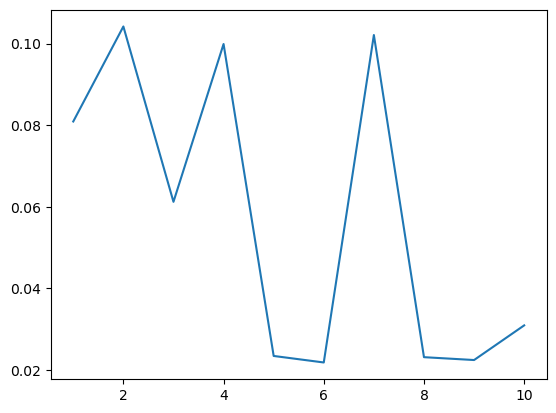

In [16]:
import numpy as np
import matplotlib.pyplot as plt

training_loss = np.array([0.0809,0.1042,0.0612,0.0999,0.0234,0.0218,0.1021,0.0231,0.0224,0.0309])
validation_loss = np.array([0.4337,0.1816,0.2100,0.5429,0.2348,0.3053,0.2060,0.1902,0.1446,0.5035])
epochs = np.array([1,2,3,4,5,6,7,8,9,10])

plt.plot(epochs,training_loss)
plt.show()


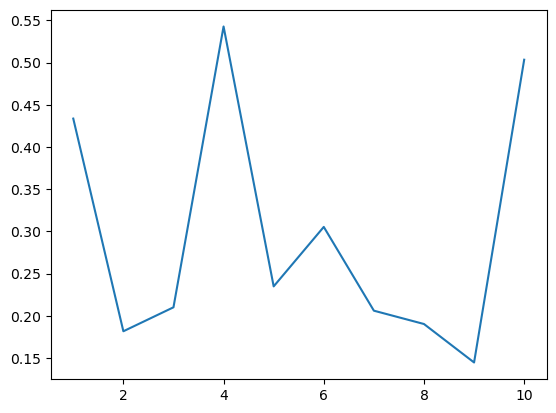

In [17]:
plt.plot(epochs,validation_loss)
plt.show()

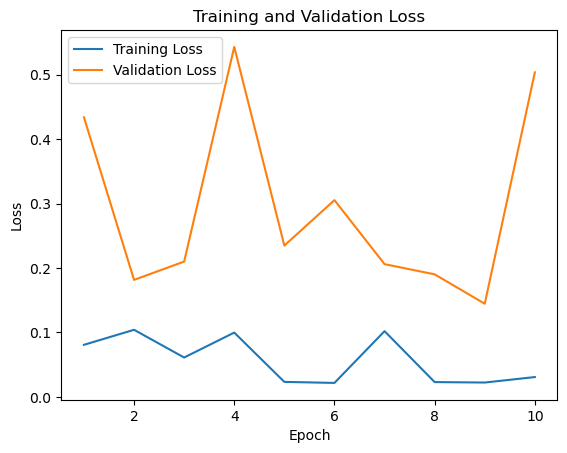

In [22]:
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()